# transformation tests

its still unclear to me which modifications of midi files are able to be applied to the `PrettyMIDI` object vs. needing to be written out to the filesystem then read back in. This notebook tests that somewhat.


## imports


In [20]:
import os
from pathlib import Path
import mido
import pretty_midi
from matplotlib import pyplot as plt

plt.style.use("dark_background")

## functions


In [8]:
def plot_prs(pr, bpr, title, bpms) -> None:
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)

    plt.subplot(2, 1, 1)
    plt.imshow(pr, aspect="auto", origin="lower", cmap="magma")
    plt.title(f"original")
    plt.xlabel("time (ms)")
    plt.ylabel("MIDI note number")
    beat_interval = 60.0 / bpms[0]  # seconds per beat
    for beat in range(8 + 1):
        plt.axvline(x=beat * beat_interval * 100, color="green", linestyle=":")

    plt.subplot(2, 1, 2)
    plt.imshow(bpr, aspect="auto", origin="lower", cmap="magma")
    plt.title(f"shifted")
    plt.xlabel("")
    plt.ylabel("")
    beat_interval = 60.0 / bpms[1]  # seconds per beat
    for beat in range(8 + 1):
        plt.axvline(x=beat * beat_interval * 100, color="green", linestyle=":")

    plt.tight_layout()
    plt.show()

In [9]:
def change_tempo(file_path: str, tempo: int) -> str:
    midi = mido.MidiFile(file_path)
    new_tempo = mido.bpm2tempo(tempo)
    new_message = mido.MetaMessage("set_tempo", tempo=new_tempo, time=0)
    tempo_added = False

    for track in midi.tracks:
        # remove existing set_tempo messages
        for msg in track:
            if msg.type == "set_tempo":
                track.remove(msg)

        # add new set_tempo message to the first track
        if not tempo_added:
            track.insert(0, new_message)
            tempo_added = True

    # if no tracks had a set_tempo message and no new one was added, add a new track with the tempo message
    if not tempo_added:
        new_track = mido.MidiTrack()
        new_track.append(new_message)
        midi.tracks.append(new_track)

    new_file_path = os.path.join("tmp", f"{Path(file_path).stem}_{tempo}.mid")
    midi.save(new_file_path)

    return new_file_path

In [10]:
def transform(file_path: str, transformations) -> str:
    new_file_path = change_tempo(file_path, transformations["tempo"])

    if transformations["transpose"] != 0:
        t_midi = pretty_midi.PrettyMIDI()

        for instrument in pretty_midi.PrettyMIDI(new_file_path).instruments:
            transposed_instrument = pretty_midi.Instrument(program=instrument.program)
            for note in instrument.notes:
                transposed_note = pretty_midi.Note(
                    velocity=note.velocity,
                    pitch=note.pitch + transformations["transpose"],
                    start=note.start,
                    end=note.end,
                )
                transposed_instrument.notes.append(transposed_note)
            t_midi.instruments.append(transposed_instrument)

        t_midi.write(new_file_path)

    if transformations["shift"] != 0:
        s_midi = pretty_midi.PrettyMIDI()
        beats_per_second = transformations["tempo"] / 60.0
        shift_seconds = transformations["shift"] / beats_per_second

        for instrument in pretty_midi.PrettyMIDI(new_file_path).instruments:
            shifted_instrument = pretty_midi.Instrument(
                program=instrument.program, is_drum=instrument.is_drum
            )
            for note in instrument.notes:
                # shift the start and end times of each note
                shifted_start = (
                    note.start + shift_seconds * transformations["shift"]
                ) % (8 / beats_per_second)
                shifted_end = (note.end + shift_seconds * transformations["shift"]) % (
                    8 / beats_per_second
                )
                if shifted_end < shifted_start:  # handle wrapping around the cycle
                    shifted_end += 8 / beats_per_second
                shifted_note = pretty_midi.Note(
                    velocity=note.velocity,
                    pitch=note.pitch,
                    start=shifted_start,
                    end=shifted_end,
                )
                shifted_instrument.notes.append(shifted_note)
            s_midi.instruments.append(shifted_instrument)

        s_midi.write(new_file_path)

    return new_file_path

In [11]:
def play_midi(file_path, output_port_name):
    mid = mido.MidiFile(file_path)

    with mido.open_output(output_port_name) as outport:  # type: ignore
        print(f"Playing {file_path} on {output_port_name}...")
        for msg in mid.play():
            if not msg.is_meta:
                outport.send(msg)

    print("Playback finished.")

## go


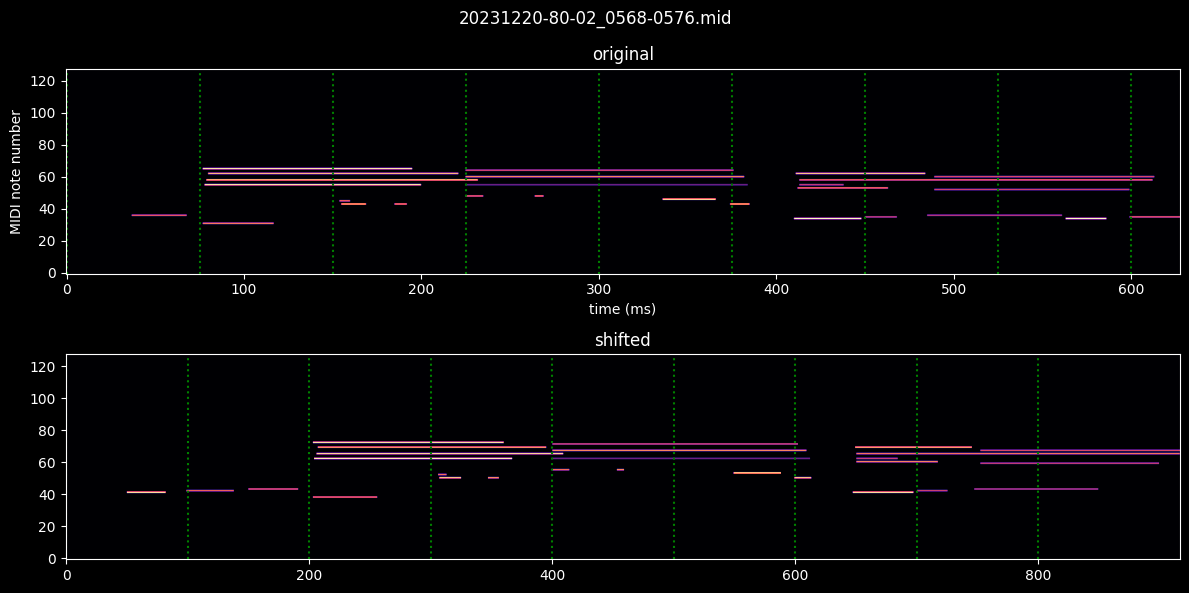

Playing tmp/20231220-80-02_0568-0576.mid on to Max 1...
Playback finished.
Playing tmp/20231220-80-02_0568-0576_60.mid on to Max 1...
Playback finished.


In [18]:
# file = "tmp/first_half.mid"
file = "tmp/20231220-80-02_0568-0576.mid"
og_pr = pretty_midi.PrettyMIDI(file).get_piano_roll()
transformations = {
    "tempo": 60,
    "shift": 1,
    "transpose": 7,
}

new_file = transform(file, transformations)
new_pr = pretty_midi.PrettyMIDI(new_file).get_piano_roll()

plot_prs(og_pr, new_pr, "20231220-80-02_0568-0576.mid", [80, 60])
play_midi(file, "to Max 1")
play_midi(new_file, "to Max 1")

In [17]:
midi = mido.MidiFile(file)
absolute_time = 0

for track in midi.tracks:
    for msg in track:
        absolute_time += mido.tick2second(msg.time, midi.ticks_per_beat, 80) * 1000
        if msg.type == "note_on" and msg.velocity > 0:
            print(f"Time: {absolute_time}, Pitch: {msg.note}")

midi.print_tracks()

Time: 0.04036363636363636, Pitch: 36
Time: 0.0829090909090909, Pitch: 31
Time: 0.0829090909090909, Pitch: 65
Time: 0.08436363636363636, Pitch: 55
Time: 0.08545454545454545, Pitch: 58
Time: 0.08618181818181818, Pitch: 62
Time: 0.16545454545454547, Pitch: 45
Time: 0.16618181818181818, Pitch: 43
Time: 0.19854545454545452, Pitch: 43
Time: 0.2403636363636363, Pitch: 48
Time: 0.2403636363636363, Pitch: 60
Time: 0.24109090909090902, Pitch: 55
Time: 0.24109090909090902, Pitch: 64
Time: 0.28290909090909083, Pitch: 48
Time: 0.35963636363636353, Pitch: 46
Time: 0.3996363636363635, Pitch: 43
Time: 0.43854545454545446, Pitch: 34
Time: 0.43963636363636355, Pitch: 62
Time: 0.4403636363636363, Pitch: 53
Time: 0.44109090909090903, Pitch: 55
Time: 0.44109090909090903, Pitch: 58
Time: 0.481090909090909, Pitch: 35
Time: 0.5185454545454544, Pitch: 36
Time: 0.5221818181818181, Pitch: 52
Time: 0.5221818181818181, Pitch: 60
Time: 0.601090909090909, Pitch: 34
Time: 0.6396363636363636, Pitch: 35
=== Track 0
Met